<a href="https://colab.research.google.com/github/BBrain778/CNN/blob/main/HW1(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#主題:使用CNN分類衛星影像中的災害從而加速災害應對




## 1.1 安裝套件(若在colab訓練每次都需要執行)

In [1]:
!pip install fastbook -q
# 安裝 gcsfs 與 datasets 支援的版本
!pip install gcsfs==2025.3.0 --no-deps
!pip install datasets==3.4.0 --no-deps



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 1.2 讀取套件

In [2]:
import fastbook
from fastbook import *
from fastai.vision.widgets import *
import torch
import shutil
from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from torchvision.transforms.functional import to_tensor
from fastai.vision.all import PILImage, Resize, ResizeMethod, PadMode
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


### 設定裝置

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
import shutil
import fastai;
print('fastai verison:', fastai.__version__)
print('torch version:', torch.__version__)

fastai verison: 2.7.19
torch version: 2.6.0+cu124



## 1.3 準備資料集

### 掛載到google drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 設定專案名稱

In [6]:
project = 'demo'
path = Path('/content/drive/MyDrive/DeepLearning/0225/dataset/'+project)

In [7]:
"""
#Key is the name of classes; value is the keyword that which search engine uses for searching
keywords = {
    'Aerial photo of the fire': 'Aerial photo of the fire',
    'Drought aerial photo': 'Drought aerial photo',
    'Aerial photo of flood': 'Aerial photo of flood',
    'Aerial photo of volcano': 'Aerial photo of volcano',
    'Typhoon satellite photos': 'Typhoon satellite photos'
}
array = keywords.items()
#Satellite photos of the fire火災衛星照片
#Drought satellite photos乾旱衛星照片
#Satellite photos of floods水災衛星照片
#Satellite photos of volcanic eruptions火山爆發衛星照片
#Satellite photos of heavy rain豪雨衛星照片
#Typhoon satellite photos颱風衛星照片

project_folder = f'/content/drive/MyDrive/DeepLearning/0225/dataset/{project}'
"""

"\n#Key is the name of classes; value is the keyword that which search engine uses for searching\nkeywords = {\n    'Aerial photo of the fire': 'Aerial photo of the fire',\n    'Drought aerial photo': 'Drought aerial photo',\n    'Aerial photo of flood': 'Aerial photo of flood',\n    'Aerial photo of volcano': 'Aerial photo of volcano',\n    'Typhoon satellite photos': 'Typhoon satellite photos'\n}\narray = keywords.items()\n#Satellite photos of the fire火災衛星照片\n#Drought satellite photos乾旱衛星照片\n#Satellite photos of floods水災衛星照片\n#Satellite photos of volcanic eruptions火山爆發衛星照片\n#Satellite photos of heavy rain豪雨衛星照片\n#Typhoon satellite photos颱風衛星照片\n\nproject_folder = f'/content/drive/MyDrive/DeepLearning/0225/dataset/{project}'\n"

In [8]:
"""
if not path.exists():
    !mkdir -p {project_folder}
else:
    print('The Project Folder exists; it will be removed and created again.')
    shutil.rmtree(project_folder)
    !mkdir -p {project_folder}

#網路爬蟲下載圖片
for key,value in array:
    print(key,value)
    dest = (path/key)
    dest.mkdir(exist_ok=True)
    urls = search_images_ddg(f' {value}',max_images=300)  # DuckDuckGo圖像搜尋引擎
    download_images(dest, urls=urls)
"""

"\nif not path.exists():\n    !mkdir -p {project_folder}\nelse:\n    print('The Project Folder exists; it will be removed and created again.')\n    shutil.rmtree(project_folder)\n    !mkdir -p {project_folder}\n\n#網路爬蟲下載圖片\nfor key,value in array:\n    print(key,value)\n    dest = (path/key)\n    dest.mkdir(exist_ok=True)\n    urls = search_images_ddg(f' {value}',max_images=300)  # DuckDuckGo圖像搜尋引擎\n    download_images(dest, urls=urls)\n"

## 1.4 清洗資料

In [9]:
fns = get_image_files(path) # 找出所有圖像檔案
failed = verify_images(fns) #將所有無效的圖像檔案路徑儲存於變數failed中
failed.map(Path.unlink) # 刪除無效的圖像檔案

(#0) []

## 2.1 設定訓練資料路徑

In [10]:
path = Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo')
path.ls()

(#5) [Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Aerial photo of the fire'),Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Drought aerial photo'),Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Aerial photo of flood'),Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Aerial photo of volcano'),Path('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Typhoon satellite photos')]

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 建立模型權重儲存路徑

In [12]:

myPath='/content/drive/MyDrive/DeepLearning/0225/models'
!mkdir -p $myPath

## 2.2 資料讀取框架

### 數據集切割比例(8:1:1)

In [13]:
dataset = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #定義輸入和輸出的資料類型(輸入:圖片/輸出:分類標籤)
    get_items=get_image_files,  #告訴 fastai 如何獲取資料
    splitter=RandomSplitter(valid_pct=0.1, seed=42),#10%的資料用於驗證集，剩下的90%用於訓練集
    item_tfms=Resize(224),#將所有圖片調整為 224x224 像素
    get_y=parent_label,#從圖片的父資料夾名稱獲取標籤
)

# 利用框架正式讀取資料
# 批次大小（batch size），每次訓練或驗證時處理 16 張圖片
# 使用 16 個workers來並行載入資料，加快資料準備速度
# dataset.dataloaders 是從你的數據集（dataset）生成一個數據加載器
dls = dataset.dataloaders(path,bs=16,num_workers=16)

# 計算分配後的資料集大小
train_size = len(dls.train_ds)
valid_size = len(dls.valid_ds)

# 計算測試集大小 (從訓練集和驗證集中總共分配 10% 作為測試集)
total_size = train_size + valid_size
test_size = int(0.1 * total_size)  # 10% 作為測試集

# 現在，更新訓練集的大小 (剩餘的 80%)
train_size = total_size - valid_size - test_size

print(f'Train: {train_size}, Validation: {valid_size}, Test: {test_size}')


Train: 752, Validation: 93, Test: 93


## 2.3 讀取圖檔結果(確保圖像已正確載入)

用於視覺化檢查資料載入器產生的圖像資料，有助於確保資料品質和正確性

訓練資料


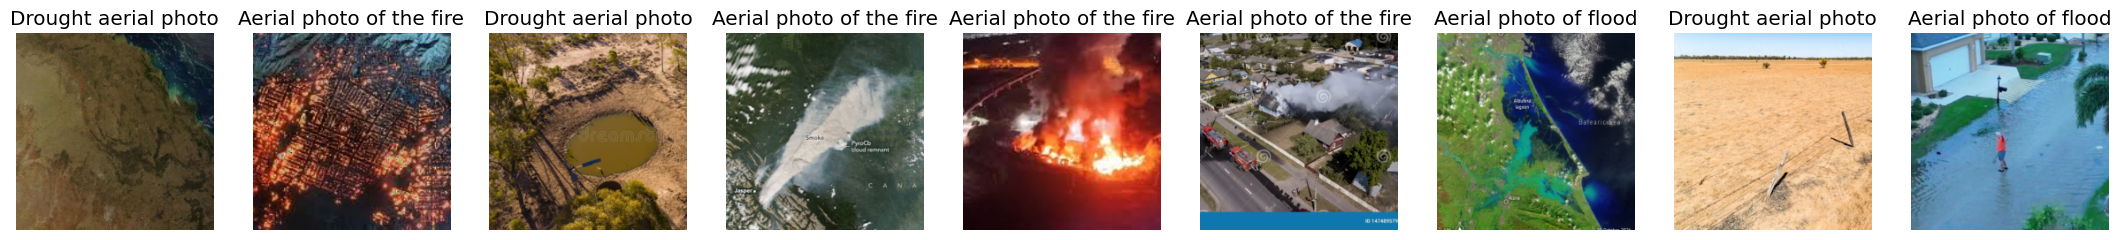

In [14]:
print('訓練資料')
dls.show_batch(max_n=9, nrows=1) #從訓練集中抽出9個樣本   nrows=顯示的行數
#這邊顯示出來的圖片和標籤是我提供給fastai的資料，不是模型自己預測的結果


## 3.1選擇模型架構以及對應的預測訓練權重

NOTE: metrics是模型訓練人員觀察的指標，可設定多個

### 定義模型列表


*   ResNet 透過殘差連接解決深層網路訓練問題。
*   VGG 透過簡單的堆疊方式加深網路。
*   EfficientNet 透過複合縮放技術，在準確度和效率之間取得平衡。

In [15]:
models = {
    "ResNet34": resnet34,
    "Vgg16": vgg16,
    "EfficientNet": efficientnet_b0
}

results = {}

## 訓練並儲存模型權重檔

微調（fine-tuning）的原理：

*   微調是在預訓練模型（例如在 ImageNet 上訓練的模型）的基礎上，針對新的資料集進行再訓練。
*   目的是讓模型能夠適應新的資料集，並提高在特定任務上的效能。

overfitting觀察

*   `train_loss` 持續下降，但 `valid_loss` 開始上升或停滯不前







In [16]:
for model_name, model_arch in models.items():
    print(f"Training {model_name}...")
    learn = vision_learner(dls, model_arch, metrics=[accuracy], pretrained=True) #pretrained=True表示使用了在 ImageNet 這樣的大型資料集上訓練過的模型
    #fine-tuning，在已經預訓練的權重上進行再訓練，共3次
    learn.fine_tune(3)

    model_path = f'/content/drive/MyDrive/DeepLearning/0225/models/{model_name}.pkl'
    learn.export(model_path)

Training ResNet34...


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 111MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.565324,0.683141,0.774194,00:46


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.890493,0.563118,0.806452,00:46
1,0.633102,0.650388,0.860215,00:46
2,0.394764,0.577352,0.838710,00:48


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training Vgg16...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.7MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.431727,0.834115,0.763441,00:43


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.764524,0.738024,0.731183,00:45
1,0.705432,0.615238,0.784946,00:44
2,0.559007,0.591049,0.795699,00:43


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing 

Training EfficientNet...


100%|██████████| 20.5M/20.5M [00:00<00:00, 155MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,1.674406,1.252451,0.677419,00:45


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.906736,1.377594,0.752688,00:46
1,0.821253,1.027034,0.752688,00:44
2,0.653108,1.006954,0.774194,00:44


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## 顯示預測結果

In [17]:
y_pred, y_true = learn.get_preds()  # 這會返回預測結果和真實標籤
print(f"y_pred shape: {y_pred.shape}, y_true shape: {y_true.shape}")
print(f"y_pred unique values: {y_pred.unique()}")
print(f"y_true unique values: {y_true.unique()}")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


y_pred shape: torch.Size([93, 5]), y_true shape: torch.Size([93])
y_pred unique values: tensor([4.0188e-12, 6.2172e-11, 4.4928e-10, 9.5768e-10, 3.1165e-09, 6.4922e-09, 1.0466e-08, 2.0593e-08, 2.2744e-08, 2.4659e-08, 2.7604e-08, 2.7830e-08, 4.0043e-08, 4.3692e-08, 4.7787e-08, 4.8087e-08,
        5.6406e-08, 5.6918e-08, 5.9414e-08, 6.5744e-08, 8.0130e-08, 8.8559e-08, 9.3408e-08, 1.0679e-07, 1.1017e-07, 1.1042e-07, 1.1331e-07, 1.7966e-07, 2.2789e-07, 2.7095e-07, 2.9256e-07, 3.1456e-07,
        3.5756e-07, 3.5806e-07, 3.8211e-07, 3.9150e-07, 4.0640e-07, 4.0850e-07, 4.2611e-07, 4.2820e-07, 4.6430e-07, 4.8662e-07, 5.8259e-07, 5.9159e-07, 7.4092e-07, 7.6907e-07, 9.2168e-07, 1.0156e-06,
        1.2656e-06, 1.5866e-06, 1.6052e-06, 1.6856e-06, 1.6875e-06, 1.7715e-06, 1.9850e-06, 2.0600e-06, 2.2148e-06, 2.2730e-06, 2.3043e-06, 2.4675e-06, 2.8200e-06, 2.8214e-06, 3.0490e-06, 3.1887e-06,
        3.2642e-06, 3.4957e-06, 3.5003e-06, 4.0649e-06, 4.1577e-06, 4.6044e-06, 5.0473e-06, 5.9828e-06, 6.2135e-

### `y_pred shape: torch.Size([93, 5])`
意味著有 93 個樣本，每個樣本有 5 個預測的機率值

### `y_true shape: torch.Size([93])`
意味著你有 93 個樣本的真實標籤。每個標籤是對應的類別編號（例如，0 到 4，這意味著有 5 類標籤）



## 預測模型的準確度

### 針對之前訓練並儲存的每個模型，載入模型、評估模型在驗證資料集上的準確度，並將結果儲存起來

In [18]:
for model_name, model_arch in models.items():
    # Load the learner for the specific model
    model_path = f'/content/drive/MyDrive/DeepLearning/0225/models/{model_name}.pkl'
    learn = load_learner(model_path) # Load the specific learner

    preds, y_true, _ = learn.get_preds(with_loss=True, dl=dls.valid) # Specify the dataloader for get_preds
    y_pred = preds.argmax(dim=1)

    # **確保 y_true 是類別索引，而不是 one-hot 編碼**
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true = y_true.argmax(dim=1)  # Convert one-hot to class index

    acc = accuracy(preds, y_true).item()

    # Print or store the accuracy for each model
    print(f"Accuracy for {model_name}: {acc}")
    results[model_name] = acc

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Accuracy for ResNet34: 0.8387096524238586


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Accuracy for Vgg16: 0.7956989407539368


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Accuracy for EfficientNet: 0.774193525314331


## 3.3解凍權重再次訓練

### 尋找最佳學習率
在訓練 AI 模型時，學習率太小，訓練會變慢；學習率太大，模型可能學不好甚至發散。這些圖幫助你找到一個 「剛剛好」 的學習率，讓訓練既快又穩定。



*   學習率太大時 (右側區域)，損失值急劇上升，代表模型開始學壞了
*   選擇橘色點 (minimum) 附近，可能會讓模型學得更準確
*   選擇綠色點 (steep) 附近，初始學習速度會快






Training ResNet34 with lr_max=9.21e-06...


epoch,train_loss,valid_loss,accuracy,time
0,0.257787,0.605815,0.838710,00:46
1,0.226569,0.572961,0.849462,00:48
2,0.208509,0.632948,0.838710,00:48
3,0.165071,0.569461,0.860215,00:46
4,0.176861,0.582443,0.827957,00:46
5,0.170355,0.589900,0.849462,00:46


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in by

Finished training ResNet34



Training Vgg16 with lr_max=6.43e-08...


epoch,train_loss,valid_loss,accuracy,time
0,0.443102,0.616189,0.784946,00:50
1,0.457748,0.604974,0.784946,00:52
2,0.436903,0.597556,0.795699,00:54
3,0.422297,0.577457,0.806452,00:49
4,0.430405,0.590319,0.795699,00:50
5,0.432450,0.603207,0.784946,00:48


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in by

Finished training Vgg16



Training EfficientNet with lr_max=4.94e-07...


epoch,train_loss,valid_loss,accuracy,time
0,0.600607,1.088678,0.752688,00:52
1,0.634104,1.027143,0.752688,00:48
2,0.615661,0.991240,0.763441,00:50
3,0.640160,0.982742,0.795699,00:50
4,0.641620,0.988799,0.774194,00:49
5,0.682431,1.030318,0.784946,00:48


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in by

Finished training EfficientNet

All models trained: {'ResNet34': {'lr_min': 9.206688264384866e-06, 'lr_steep': 7.680359317419061e-07}, 'Vgg16': {'lr_min': 6.432678674173076e-08, 'lr_steep': 8.392211157115526e-07}, 'EfficientNet': {'lr_min': 4.940528469887795e-07, 'lr_steep': 2.656497827047133e-06}}


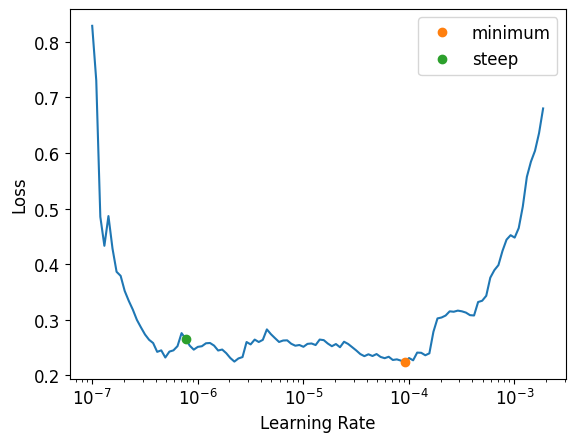

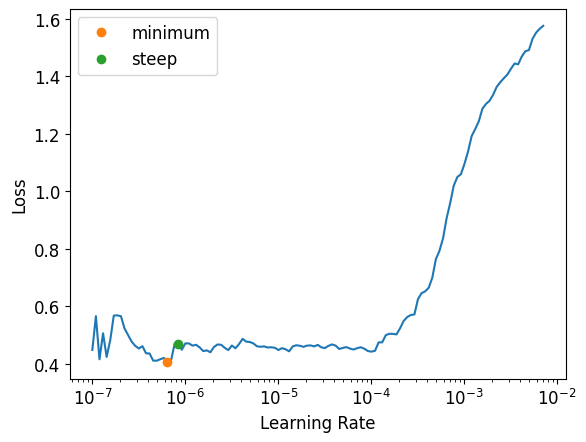

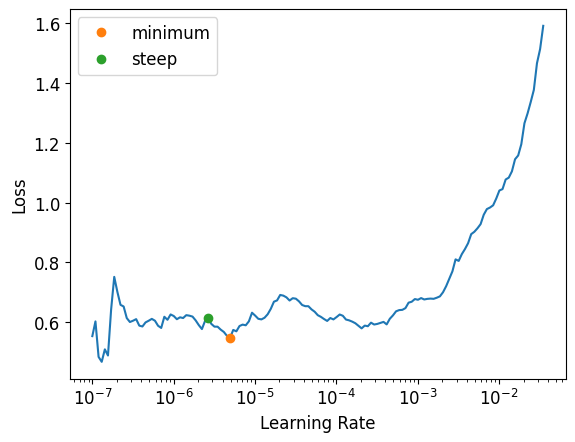

In [19]:
results = {}
for model_name, model_arch in models.items():
    # 讀取模型
    model_path = f'/content/drive/MyDrive/DeepLearning/0225/models/{model_name}.pkl'
    learn = load_learner(model_path)

    # 確保 DataLoaders 設置正確
    learn.dls = dls
    learn.unfreeze()

    # 找最佳學習率
    lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep), end_lr=5, num_it=200)

    # 訓練 6 個 epochs
    print(f"Training {model_name} with lr_max={lr_min:.2e}...")
    learn.fit_one_cycle(6, lr_max=lr_min)

    # 記錄結果
    results[model_name] = {'lr_min': lr_min, 'lr_steep': lr_steep}
    print(f"Finished training {model_name}\n")

print("All models trained:", results)


## 3.4儲存新的權重

In [20]:
export_path = "/content/drive/MyDrive/DeepLearning/0225/models/exported"  # 設定存放路徑
os.makedirs(export_path, exist_ok=True)  # 確保目錄存在

for model_name, model_arch in models.items():
    # 讀取模型
    model_path = f'/content/drive/MyDrive/DeepLearning/0225/models/{model_name}.pkl'
    learn = load_learner(model_path)

    # 確保模型正確載入
    if learn is None:
        print(f"Skipping {model_name}: Failed to load model.")
        continue

    # 設定輸出路徑
    export_file = f"{export_path}/{model_name}_export.pkl"

    # 導出模型
    learn.export(export_file)
    print(f"Exported {model_name} to {export_file}")

print("All models exported successfully!")


Exported ResNet34 to /content/drive/MyDrive/DeepLearning/0225/models/exported/ResNet34_export.pkl


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


Exported Vgg16 to /content/drive/MyDrive/DeepLearning/0225/models/exported/Vgg16_export.pkl


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


Exported EfficientNet to /content/drive/MyDrive/DeepLearning/0225/models/exported/EfficientNet_export.pkl
All models exported successfully!


## 4.1結果檢核(Confusion Matrix)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Confusion Matrix for ResNet34:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Confusion Matrix for Vgg16:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Confusion Matrix for EfficientNet:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


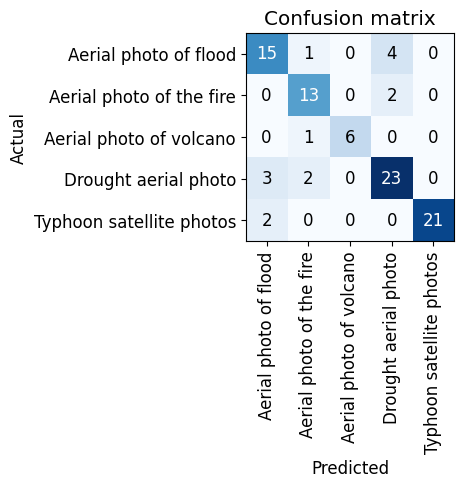

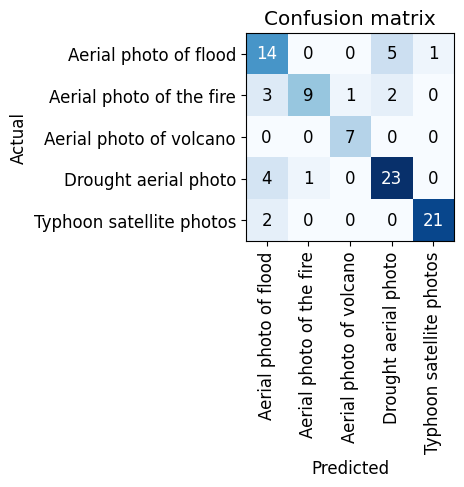

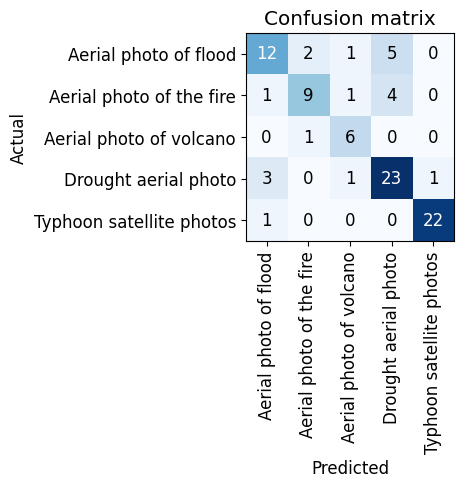

In [21]:
# Iterate through each model
for model_name, model_arch in models.items():
    # Load the learner for the specific model
    model_path = f'/content/drive/MyDrive/DeepLearning/0225/models/exported/{model_name}_export.pkl'
    learn = load_learner(model_path)  # Load the specific learner

    # Get predictions and true labels
    preds, y_true, _ = learn.get_preds(with_loss=True, dl=dls.valid)  # Specify the dataloader for get_preds
    y_pred = preds.argmax(dim=1)

    # Create interpretation object
    interp = ClassificationInterpretation.from_learner(learn, dl=dls.valid)

    # Plot confusion matrix
    print(f"Confusion Matrix for {model_name}:")
    interp.plot_confusion_matrix()


### 找出每個模型預測錯誤最嚴重的樣本

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Top 5 losses for ResNet34:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Top 5 losses for Vgg16:


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Top 5 losses for EfficientNet:


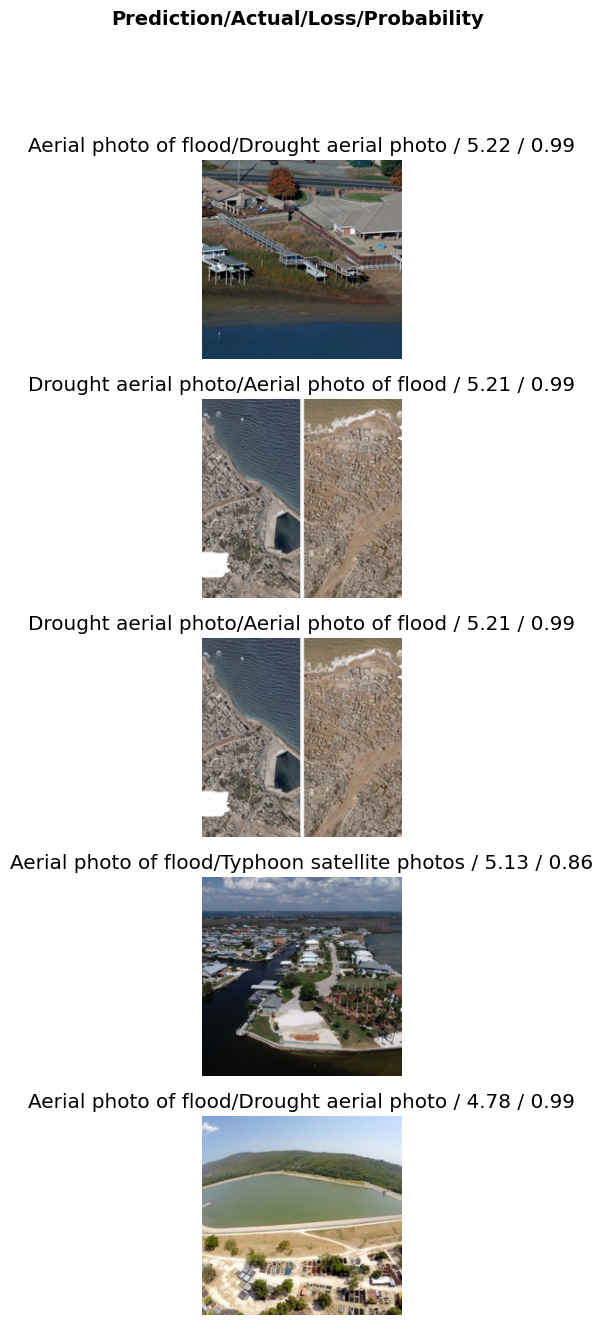

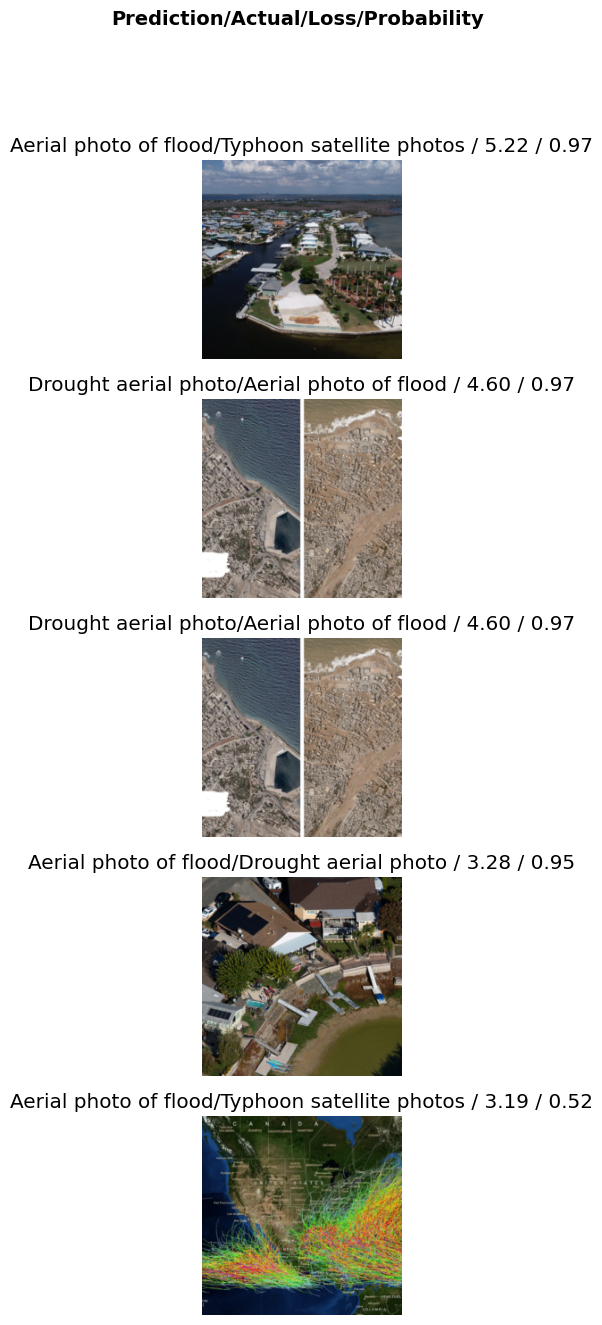

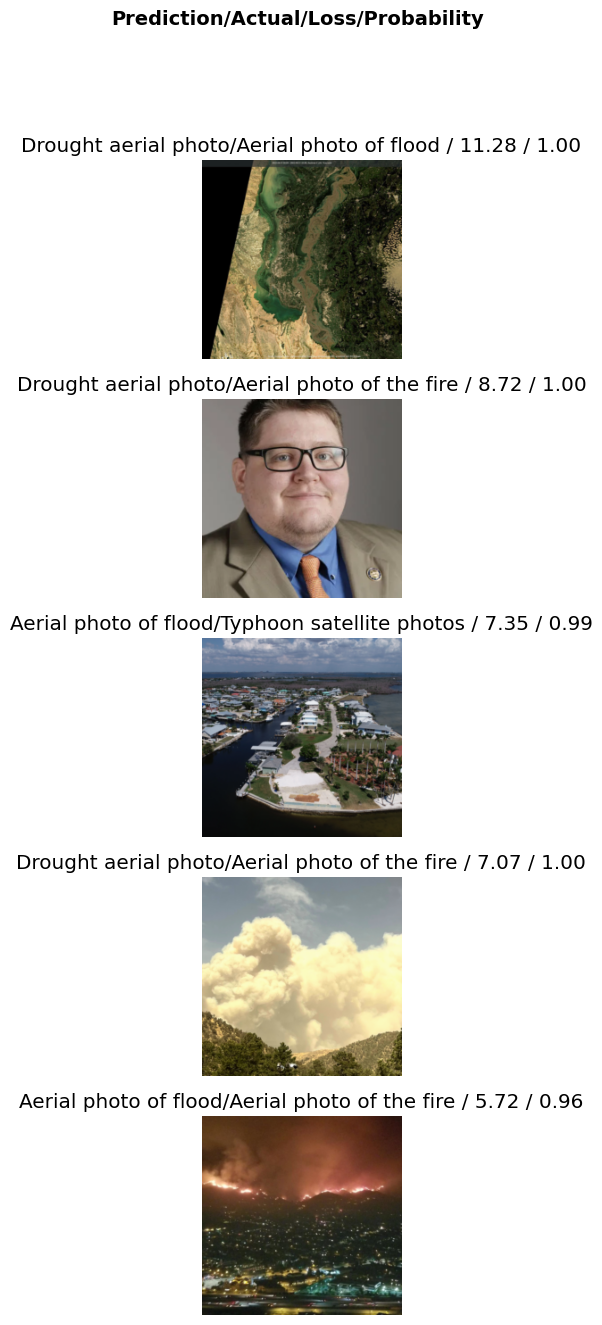

In [22]:
# 迭代每個模型
for model_name, model_arch in models.items():
    # 使用新的權重檔案來加載模型
    new_model_path = f'/content/drive/MyDrive/DeepLearning/0225/models/exported/{model_name}_export.pkl'
    learn = load_learner(new_model_path)  # 加載新的學習器

    # 獲取預測結果和真實標籤
    preds, y_true, _ = learn.get_preds(with_loss=True, dl=dls.valid)  # 指定dataloader進行預測
    y_pred = preds.argmax(dim=1)

    # 創建解釋對象
    interp = ClassificationInterpretation.from_learner(learn, dl=dls.valid)

    # 顯示前 5 個錯誤最嚴重的分類結果
    print(f"Top 5 losses for {model_name}:")
    interp.plot_top_losses(5, nrows=5)


## 預測

In [23]:
## 模型位置
from fastbook import *
from fastai.vision.widgets import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 5.1讀取先前訓練好的權重

In [24]:
myPath = '/content/drive/MyDrive/DeepLearning/0225/models/exported/'

# List your model files
model_files = [
    'ResNet34_export.pkl',
    'Vgg16_export.pkl',
    'EfficientNet_export.pkl'
]

# Load all the models
learners = []
for model_file in model_files:
    model_path = f'{myPath}/{model_file}'
    learn = load_learner(model_path)  # Load the model
    learners.append(learn)  # Store each learner in the list

# Now you have a list `learners` that contains the loaded models


## 5.2讀取檔案並送入模型預測

In [25]:
##執行預測 -method I
# get_image_files is now available
fnames_fire = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Aerial photo of the fire')
fnames_Drought = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Drought aerial photo')
fnames_floods = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Aerial photo of flood')
fnames_volcanic = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Aerial photo of volcano')
fnames_Typhoon = get_image_files('/content/drive/MyDrive/DeepLearning/0225/dataset/demo/Typhoon satellite photos')


print(f"Number of fire images: {len(fnames_fire)}")
print(f"Number of drought images: {len(fnames_Drought)}")
print(f"Number of floods images: {len(fnames_floods)}")
print(f"Number of volcano images: {len(fnames_volcanic)}")
print(f"Number of typhoon images: {len(fnames_Typhoon)}")

Number of fire images: 202
Number of drought images: 231
Number of floods images: 230
Number of volcano images: 90
Number of typhoon images: 185


### 對多個類別的圖片進行預測

In [26]:
#  learners 是已經加載的多個模型列表
categories = {
    "Fire": fnames_fire,
    "Drought": fnames_Drought,
    "Floods": fnames_floods,
    "Volcanic": fnames_volcanic,
    "Typhoon": fnames_Typhoon
}

# 儲存每個類別的預測結果
category_predictions = {}

# 針對每個類別的影像進行預測
for category, fnames in categories.items():
    category_predictions[category] = []  # 初始化該類別的預測列表

    for learn in learners:
        # 檢查列表中是否有足夠的影像數量
        if len(fnames) > 3:
            # 預測該類別中的第 4 張圖片（索引為 3）
            pred_class, pred_idx, outputs = learn.predict(fnames[3])
            category_predictions[category].append((learn, pred_class))  # 儲存每個模型的預測結果
            print(f"Model Prediction for {category}: {pred_class}")
        else:
            print(f"{category} does not have enough elements to access index 3")

# 顯示所有類別的預測結果
print("All model predictions for each category:")
for category, predictions in category_predictions.items():
    print(f"\nPredictions for {category}:")
    for model, pred in predictions:
        print(f"Model: {model} - Predicted Class: {pred}")


Model Prediction for Fire: Aerial photo of the fire


Model Prediction for Fire: Aerial photo of the fire


Model Prediction for Fire: Aerial photo of the fire


Model Prediction for Drought: Drought aerial photo


Model Prediction for Drought: Drought aerial photo


Model Prediction for Drought: Drought aerial photo


Model Prediction for Floods: Aerial photo of flood


Model Prediction for Floods: Aerial photo of flood


Model Prediction for Floods: Aerial photo of flood


Model Prediction for Volcanic: Aerial photo of volcano


Model Prediction for Volcanic: Aerial photo of volcano


Model Prediction for Volcanic: Aerial photo of volcano


Model Prediction for Typhoon: Typhoon satellite photos


Model Prediction for Typhoon: Typhoon satellite photos


Model Prediction for Typhoon: Typhoon satellite photos
All model predictions for each category:

Predictions for Fire:
Model: <fastai.learner.Learner object at 0x7b9fdf50e690> - Predicted Class: Aerial photo of the fire
Model: <fastai.learner.Learner object at 0x7b9fdf50f7d0> - Predicted Class: Aerial photo of the fire
Model: <fastai.learner.Learner object at 0x7b9fdf1ba110> - Predicted Class: Aerial photo of the fire

Predictions for Drought:
Model: <fastai.learner.Learner object at 0x7b9fdf50e690> - Predicted Class: Drought aerial photo
Model: <fastai.learner.Learner object at 0x7b9fdf50f7d0> - Predicted Class: Drought aerial photo
Model: <fastai.learner.Learner object at 0x7b9fdf1ba110> - Predicted Class: Drought aerial photo

Predictions for Floods:
Model: <fastai.learner.Learner object at 0x7b9fdf50e690> - Predicted Class: Aerial photo of flood
Model: <fastai.learner.Learner object at 0x7b9fdf50f7d0> - Predicted Class: Aerial photo of flood
Model: <fastai.learner.Learner object at

## ROC curve



*   橫軸是假陽性率（FPR），縱軸是真陽性率（TPR）
*   ROC 曲線（Receiver Operating Characteristic Curve，接收者操作特徵曲線）是一種用於評估分類模型性能的圖形工具，特別是在二元分類問題中（例如判斷「是/否」、「正/負」）
*   AUC（Area Under the Curve） 是 ROC 曲線下的面積，範圍從 0 到 1
*   AUC 的解釋
  *   AUC=1：完美模型，100%正確分類。
  *   AUC=0.5：隨機猜測，模型毫無區分能力（ROC 曲線是一條對角線）。
  *   AUC<0.5：模型比隨機猜測還差（可能是標籤錯誤或模型反向預測）。











/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


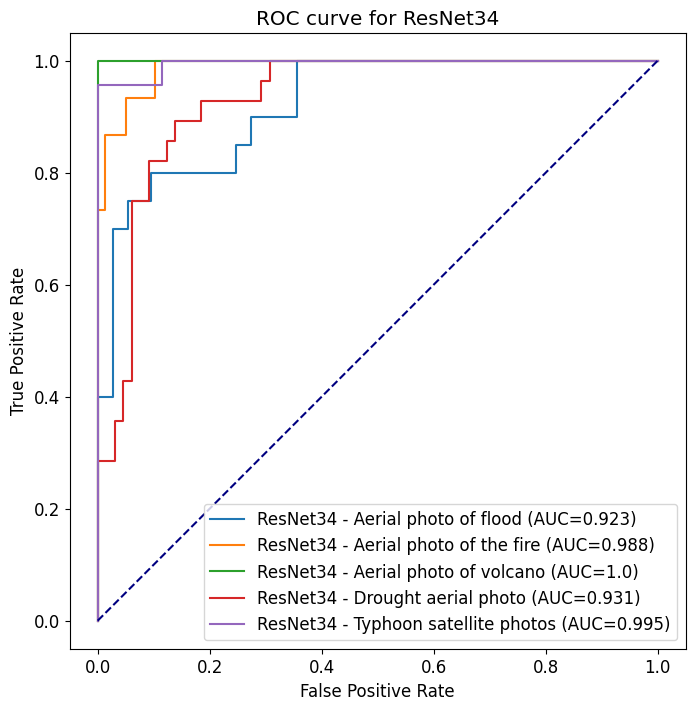

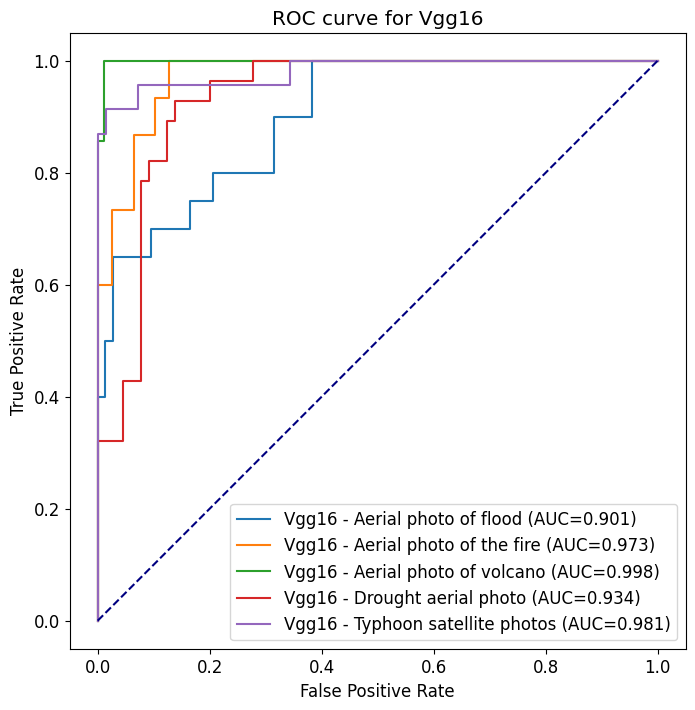

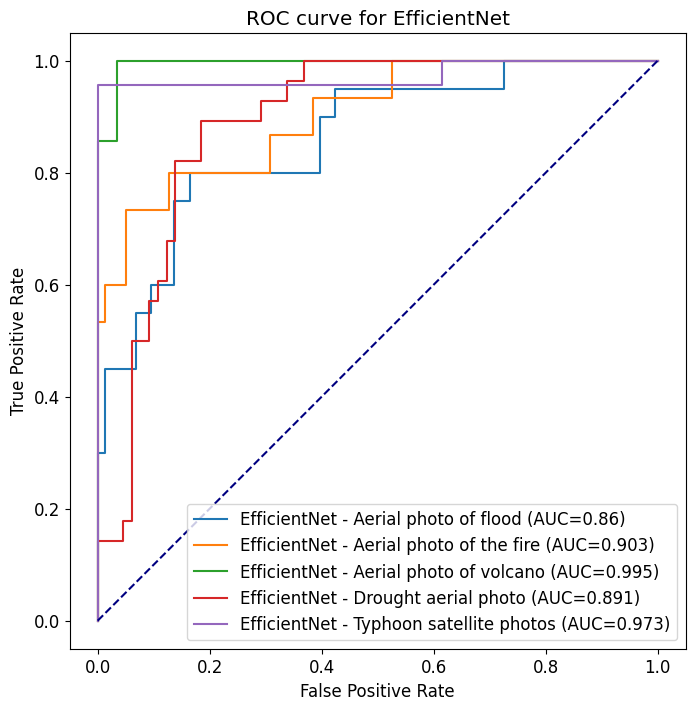

In [27]:
# 假設 learners 是一個包含三個已加載模型的列表
models = ["ResNet34", "Vgg16", "EfficientNet"]  # 這是你的模型名稱
learners = []  # 這是包含你三個已加載模型的 learners 列表
myPath = '/content/drive/MyDrive/DeepLearning/0225/models/exported/'

# List your model files
model_files = [
    'ResNet34_export.pkl',
    'Vgg16_export.pkl',
    'EfficientNet_export.pkl'
]

# Load all the models and add them to the 'learners' list
for model_file in model_files:
    model_path = f'{myPath}/{model_file}'
    learn = load_learner(model_path)  # Load the model
    learners.append(learn)  # Store each learner in the list


# 讀取資料集（用於獲取 y）
preds_all_models = []
y_all_models = []

# 取得所有模型的預測結果
for learn in learners:
    preds, y, _ = learn.get_preds(with_loss=True, dl=dls.valid)  # 獲取預測結果和真實標籤
    preds_all_models.append(preds)
    y_all_models.append(y)

# 設定類別數和類別名稱
class_num = dls.c
class_name = dls.vocab

# 迴圈繪製每個模型的ROC曲線並保存為獨立的圖片
for model_idx, (preds, y) in enumerate(zip(preds_all_models, y_all_models)):
    # 為每個模型創建新圖
    plt.figure(figsize=(8, 8))

    # 迭代每個類別
    for i in range(class_num):
        probs = np.array(preds[:, i])

        # 計算ROC曲線
        fpr, tpr, thresholds = roc_curve(y, probs, pos_label=i)

        # 計算AUC
        roc_auc = auc(fpr, tpr)

        # 繪製ROC曲線
        plt.plot(fpr, tpr, label=f'{models[model_idx]} - {class_name[i]} (AUC={round(roc_auc, 3)})')

    # 繪製對角線（隨機猜測的線）
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

    # 設定繪圖範圍和標籤
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.axis('square')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curve for {models[model_idx]}")
    plt.legend(loc="lower right")

    ## 顯示roc curve
    plt.show()

    # 儲存每個模型的ROC圖
    plt.savefig(f'/content/drive/MyDrive/DeepLearning/0225/models/exported/{models[model_idx]}_roc_curve.png')
    plt.close()  # 關閉該圖表，避免重疊



In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# 模型名稱
models = ["ResNet34", "Vgg16", "EfficientNet"]

# 儲存每個模型的結果
model_results = {}

# 取得所有模型的預測結果
for model_idx, (preds, y) in enumerate(zip(preds_all_models, y_all_models)):
    # 取得每個模型的預測結果和真實標籤
    y_true = y
    y_pred = np.argmax(preds, axis=1)  # 假設預測結果是概率，選擇最高的預測類別

    # 計算每個模型的各種指標
    accuracy = accuracy_score(y_true, y_pred)

     # 計算 Precision、Recall、F1-Score（Micro 和 Macro）
    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_macro = precision_score(y_true, y_pred, average='macro')

    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_macro = recall_score(y_true, y_pred, average='macro')

    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    # 計算 AUC（Weighted 和 Macro）
    auc_weighted = roc_auc_score(y_true, preds, multi_class='ovr', average='weighted')
    auc_macro = roc_auc_score(y_true, preds, multi_class='ovr', average='macro')

    # 儲存結果
    model_results[models[model_idx]] = {
        'Accuracy': accuracy,
        'Precision (Micro)': precision_micro,
        'Precision (Macro)': precision_macro,
        'Recall (Micro)': recall_micro,
        'Recall (Macro)': recall_macro,
        'F1-Score (Micro)': f1_micro,
        'F1-Score (Macro)': f1_macro,
        'AUC (Weighted)': auc_weighted,
        'AUC (Macro)': auc_macro
    }

    # 顯示每個模型的指標
    print(f"Metrics for {models[model_idx]}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Micro): {precision_micro:.4f} | Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Micro): {recall_micro:.4f} | Recall (Macro): {recall_macro:.4f}")
    print(f"F1-Score (Micro): {f1_micro:.4f} | F1-Score (Macro): {f1_macro:.4f}")
    print(f"AUC (Weighted): {auc_weighted:.4f} | AUC (Macro): {auc_macro:.4f}")
    print("-" * 50)

# 顯示所有模型的結果
print("Summary of Model Performance:")
for model_name, results in model_results.items():
    print(f"\n{model_name}:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")


Metrics for ResNet34:
Accuracy: 0.8387
Precision (Micro): 0.8387 | Precision (Macro): 0.8616
Recall (Micro): 0.8387 | Recall (Macro): 0.8417
F1-Score (Micro): 0.8387 | F1-Score (Macro): 0.8494
AUC (Weighted): 0.9594 | AUC (Macro): 0.9673
--------------------------------------------------
Metrics for Vgg16:
Accuracy: 0.7957
Precision (Micro): 0.7957 | Precision (Macro): 0.8210
Recall (Micro): 0.7957 | Recall (Macro): 0.8069
F1-Score (Micro): 0.7957 | F1-Score (Macro): 0.8062
AUC (Weighted): 0.9496 | AUC (Macro): 0.9574
--------------------------------------------------
Metrics for EfficientNet:
Accuracy: 0.7742
Precision (Micro): 0.7742 | Precision (Macro): 0.7596
Recall (Micro): 0.7742 | Recall (Macro): 0.7670
F1-Score (Micro): 0.7742 | F1-Score (Macro): 0.7577
AUC (Weighted): 0.9143 | AUC (Macro): 0.9244
--------------------------------------------------
Summary of Model Performance:

ResNet34:
Accuracy: 0.8387
Precision (Micro): 0.8387
Precision (Macro): 0.8616
Recall (Micro): 0.8387

##6.Visualization with Grad-CAM

Class Activation Mapping（類激活映射，簡稱CAM）是一種用於解釋卷積神經網路（CNN）預測的可視化技術。它可以幫助我們理解CNN在圖像分類任務中，哪些區域對最終預測貢獻最大。簡單來說，CAM生成一個熱圖（heatmap），顯示圖像中哪些部分對某個特定類別的預測最重要。



載入權重時發生錯誤 (weights_only=True): 'str' object has no attribute '__module__'
嘗試使用 load_learner 載入整個 Learner 物件...
成功使用 load_learner 載入模型。
torch.Size([1, 3, 224, 224]) <class 'torch.Tensor'>


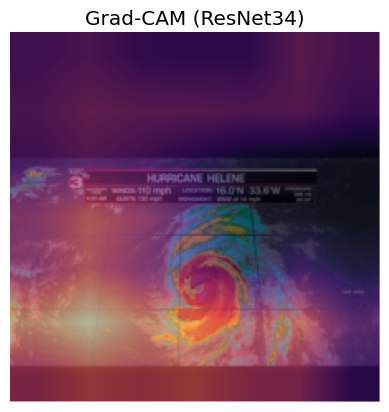

In [61]:
import torch
import torchvision.models as models
from fastai.data.core import TfmdDL # 導入 TfmdDL
from fastai.learner import load_learner # 導入 load_learner

# 允許 Fastai 的特定全局變數
torch.serialization.add_safe_globals(['TfmdDL'])

# 載入 ResNet34 模型結構 (pretrained=False 表示不使用預訓練權重)
model_arch = models.resnet34 # 先儲存模型架構，但這裡實際上不會用到載入權重
# model = models.resnet34(pretrained=False) # 註釋掉這行

# 載入你的權重檔案
weights_path = '/content/drive/MyDrive/DeepLearning/0225/models/exported/ResNet34_export.pkl'
try:
    checkpoint = torch.load(weights_path, weights_only=True)
    # 我們知道檔案是 Fastai Learner，所以這裡的程式碼可能不會成功執行
    model = model_arch(pretrained=False) # 重新創建模型結構
    model.load_state_dict(checkpoint['model'])
    print("成功使用 weights_only=True 載入模型。")
except Exception as e:
    print(f"載入權重時發生錯誤 (weights_only=True): {e}")
    print("嘗試使用 load_learner 載入整個 Learner 物件...")
    try:
        learn = load_learner(weights_path) # 使用 Fastai 的 load_learner 直接載入整個 Learner 物件
        model = learn.model # 從 Learner 物件中取出模型
        model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        print("成功使用 load_learner 載入模型。")
    except Exception as e2:
        print(f"使用 load_learner 載入時也發生錯誤: {e2}")
        print("請檢查你的權重檔案是否為有效的 Fastai export 檔案")
else:
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

# 後續的 Grad-CAM 程式碼
from torchvision.transforms.functional import to_tensor
from fastai.vision.all import PILImage, Resize, ResizeMethod, PadMode
import matplotlib.pyplot as plt

fn = test_dl.items[1] #第2張影像
x_dec = PILImage.create(fn);
rsz = Resize(224, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros)
x_dec = rsz(x_dec)
x = to_tensor(x_dec).unsqueeze(0).to(device)
print(x.shape,type(x))

cls = 1
target_layer = next(filter(lambda p: isinstance(p, torch.nn.Conv2d), reversed(list(model.modules())))) # 自動尋找最後一個卷積層

with HookBwd(target_layer) as hookg:
    with Hook(target_layer) as hook:
        output = model.eval()(x)
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)

_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
            interpolation='bilinear', cmap='magma')

# 直接設定模型名稱為 "ResNet34"
ax.set_title(f"Grad-CAM (ResNet34)")

plt.show()